In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import os
import shutil
import random
import cv2
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import torchvision.transforms as transforms
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder

In [2]:
# خواندن دیتا ها
!unzip "/content/drive/MyDrive/Project/Dataset/train.zip" -d "/content/train"
!unzip "/content/drive/MyDrive/Project/Dataset/validation.zip" -d "/content/validation"

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/test/night (3124).jpg  
  inflating: /content/train/test/night (3124).xml  
  inflating: /content/train/test/night (3125).jpg  
  inflating: /content/train/test/night (3125).xml  
  inflating: /content/train/test/night (3126).jpg  
  inflating: /content/train/test/night (3126).xml  
  inflating: /content/train/test/night (3127).jpg  
  inflating: /content/train/test/night (3127).xml  
  inflating: /content/train/test/night (3128).jpg  
  inflating: /content/train/test/night (3128).xml  
  inflating: /content/train/test/night (3129).jpg  
  inflating: /content/train/test/night (3129).xml  
  inflating: /content/train/test/night (3130).jpg  
  inflating: /content/train/test/night (3130).xml  
  inflating: /content/train/test/night (3131).jpg  
  inflating: /content/train/test/night (3131).xml  
  inflating: /content/train/test/night (3132).jpg  
  inflating: /content/train/test/night (3132).xml  
  inflating: 

In [3]:
# مسیر استخراج فایل‌ها
train_extract_path = "/content/train/train"
validation_extract_path = "/content/validation/validation"

# نمایش تعداد فایل‌های استخراج شده برای بررسی
train_files = os.listdir(train_extract_path)
validation_files = os.listdir(validation_extract_path)

print(f"count of train files: {len(train_files)}")
print(f"count of validation files: {len(validation_files)}")

count of train files: 8352
count of validation files: 4240


In [4]:
# نمایش محتویات پوشه‌های train و validation
print("Train files:", os.listdir(train_extract_path)[:10])
print("Validation files:", os.listdir(validation_extract_path)[:10])

Train files: ['night (1049).jpg', 'day_04283.jpg', 'day_12474.xml', 'day_04374.jpg', 'night (3063).jpg', 'day_14810.jpg', 'day_12018.xml', 'day_06840.xml', 'day_09398.xml', 'day_11323.jpg']
Validation files: ['night (2039).jpg', 'day_03285.jpg', 'day_14941.xml', 'day_08253.jpg', 'day_14305.jpg', 'day_07644.jpg', 'day_08424.jpg', 'day_01750.xml', 'day_07000.jpg', 'day_05965.xml']


In [5]:
# حذف فایل‌های با نام "night" از دایرکتوری train
for filename in os.listdir(train_extract_path):
    if filename.startswith("night"):
        file_path = os.path.join(train_extract_path, filename)
        os.remove(file_path)

# حذف فایل‌های با نام "night" از دایرکتوری validation
for filename in os.listdir(validation_extract_path):
    if filename.startswith("night"):
        file_path = os.path.join(validation_extract_path, filename)
        os.remove(file_path)

# بررسی مجدد پوشه‌ها پس از حذف تصاویر شب
print("Remaining train files:", os.listdir(train_extract_path)[:10])
print("Remaining validation files:", os.listdir(validation_extract_path)[:10])

print(f"Remaining train files count: {len(os.listdir(train_extract_path))}")
print(f"Remaining validation files count: {len(os.listdir(validation_extract_path))}")

Remaining train files: ['day_04283.jpg', 'day_12474.xml', 'day_04374.jpg', 'day_14810.jpg', 'day_12018.xml', 'day_06840.xml', 'day_09398.xml', 'day_11323.jpg', 'day_11513.xml', 'day_15533.xml']
Remaining validation files: ['day_03285.jpg', 'day_14941.xml', 'day_08253.jpg', 'day_14305.jpg', 'day_07644.jpg', 'day_08424.jpg', 'day_01750.xml', 'day_07000.jpg', 'day_05965.xml', 'day_10739.jpg']
Remaining train files count: 6702
Remaining validation files count: 3416


In [6]:
# تابع استخراج مختصات پلاک از فایل XML
def get_plate_coordinates(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    for obj in root.iter('object'):
        name = obj.find('name').text
        if name == "کل ناحیه پلاک":
            bndbox = obj.find('bndbox')
            # Convert to float first, then to int
            xmin = int(float(bndbox.find('xmin').text))
            ymin = int(float(bndbox.find('ymin').text))
            xmax = int(float(bndbox.find('xmax').text))
            ymax = int(float(bndbox.find('ymax').text))
            return [xmin, ymin, xmax, ymax]
    return None
# تست نمونه
sample_xml_path = os.path.join(train_extract_path, "day_00010.xml")  # تغییر نام فایل نمونه به نام موجود
plate_coordinates = get_plate_coordinates(sample_xml_path)
print("sample plate cordinates:", plate_coordinates)


sample plate cordinates: [850, 383, 906, 402]


In [7]:
# تنظیمات پیش‌پردازش برای تغییر اندازه و تقویت داده‌ها
target_size = (416, 416)
transform = transforms.Compose([
    transforms.Resize(target_size),
    transforms.RandomHorizontalFlip(),  # تقویت داده‌ها: چرخش افقی
    transforms.RandomAdjustSharpness(2),  # تقویت داده‌ها: افزایش وضوح
    transforms.RandomRotation(10),  # تقویت داده‌ها: چرخش
    transforms.ToTensor()  # تبدیل به تنسور
])

In [8]:
# تابع پیش‌پردازش تصویر
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")  # تبدیل به RGB
    image = transform(image)  # اعمال تنظیمات تغییر اندازه و تقویت داده‌ها
    return image

In [9]:
# تست نمونه
sample_image_path = os.path.join(train_extract_path, "day_00010.jpg")
processed_image = preprocess_image(sample_image_path)
print("processed sample image shape:", processed_image.shape)

processed sample image shape: torch.Size([3, 416, 416])


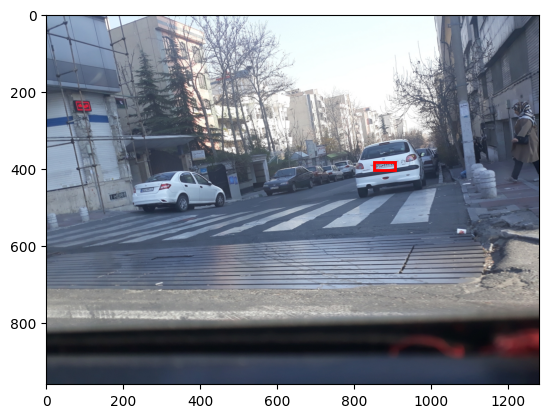

In [10]:
def show_image_with_bounding_box(image_path, bbox):
    image = Image.open(image_path).convert("RGB")
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # رسم مستطیل پلاک
    xmin, ymin, xmax, ymax = bbox
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.show()

# نمایش تصویر نمونه
if plate_coordinates:
    show_image_with_bounding_box(sample_image_path, plate_coordinates)
else:
    print("No plate cordinates found for this picture!")

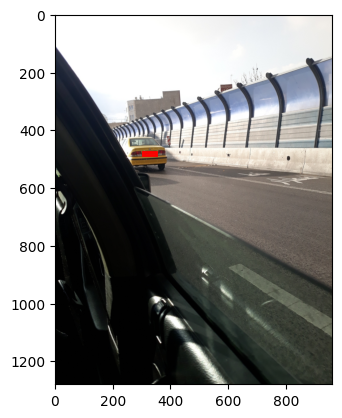

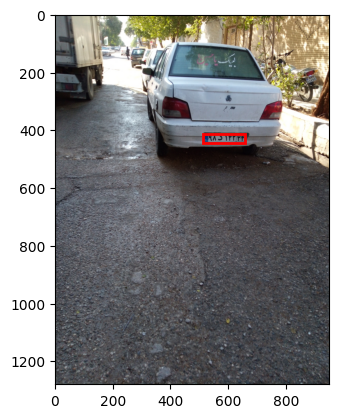

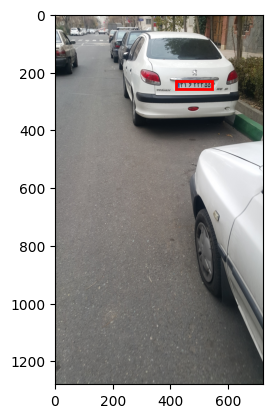

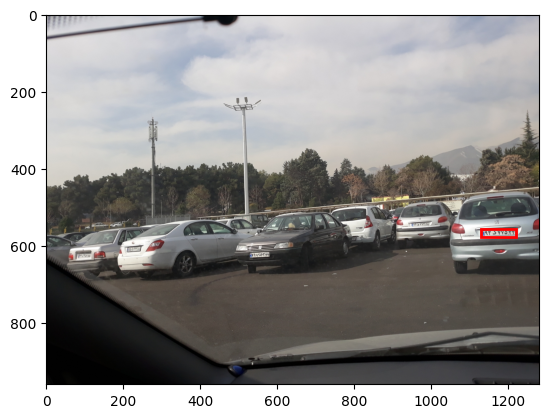

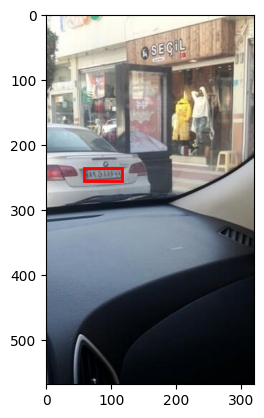

In [11]:
# انتخاب تصادفی چند نمونه برای نمایش
image_paths = [os.path.join(train_extract_path, f) for f in os.listdir(train_extract_path) if f.endswith('.jpg')]

sample_images = random.sample(image_paths, 5)

for img_path in sample_images:
    bbox = get_plate_coordinates(img_path.replace(".jpg", ".xml"))
    if bbox:
        show_image_with_bounding_box(img_path, bbox)
    else:
        print(f"No plate cordinates found for {img_path} !")

In [12]:
class LicensePlateDataset(Dataset):
    def __init__(self, image_paths, xml_paths, transform=None):
        self.image_paths = image_paths
        self.xml_paths = xml_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        xml_path = self.xml_paths[idx]

        # باز کردن تصویر
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # استخراج مختصات پلاک از فایل XML با استفاده از تابع get_plate_coordinates
        bbox = get_plate_coordinates(xml_path)

        # تبدیل bbox به قالب PyTorch در صورتی که bbox موجود باشد
        if bbox:
            bbox = torch.tensor([bbox], dtype=torch.float32)  # به شکل [N, 4]
            labels = torch.tensor([1], dtype=torch.int64)  # برچسب 1 برای پلاک
            target = {"boxes": bbox, "labels": labels}
        else:
            target = {"boxes": torch.empty((0, 4), dtype=torch.float32), "labels": torch.empty((0,), dtype=torch.int64)}

        return image, target

def collate_fn(batch):
    images, targets = zip(*batch)
    return list(images), list(targets)

In [13]:
# لیست مسیرهای تصاویر و XMLها برای داده‌های آموزشی
train_image_paths = [img_path for img_path in image_paths if "train" in img_path and not img_path.startswith("night")]

train_xml_paths = [img_path.replace(".jpg", ".xml") for img_path in train_image_paths]

# ایجاد مجموعه داده و DataLoader برای آموزش
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((416, 416)),  # تغییر اندازه به ورودی YOLO
])

train_dataset = LicensePlateDataset(train_image_paths, train_xml_paths, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))


In [21]:
# بارگذاری مدل YOLOv3 پیش‌آموزش‌داده‌شده
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
model.to(device)

# تغییر تنظیمات مدل برای تشخیص یک کلاس پلاک خودرو
num_classes = 2  # پلاک خودرو و پس‌زمینه
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [22]:
# تنظیمات اولیه برای آموزش
batch_size = 4
learning_rate = 0.001
num_epochs = 10

# تنظیمات بهینه‌ساز
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()


In [25]:
# حلقه آموزشی
for epoch in range(num_epochs):
  # تنظیم مدل برای حالت آموزش
  model.train()
  for images, targets in train_loader:
        # Move images and targets to the device
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets] # Move all tensors in targets to device

        optimizer.zero_grad()

        # Make sure model is on the correct device
        model.to(device)  # Ensure model is on the device

        # محاسبه‌ی ضرر
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # محاسبه گرادیان‌ها و به‌روزرسانی پارامترها
        losses.backward()
        optimizer.step()

  print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {losses.item():.4f}")

Epoch [1/10], Loss: 0.3406
Epoch [2/10], Loss: 9.3514
Epoch [3/10], Loss: 9600.7676
Epoch [4/10], Loss: 12774.3408
Epoch [5/10], Loss: 16065.2803
Epoch [6/10], Loss: 3273.6580
Epoch [7/10], Loss: 17.3714
Epoch [8/10], Loss: 2154377.2500
Epoch [9/10], Loss: 967.4855
Epoch [10/10], Loss: 179.9884


In [ ]:
# تابع ارزیابی با معیارهای IOU و MAP
def evaluate_model(model, validation_loader):
    model.eval()
    iou_scores = []
    for images, targets in validation_loader:
        images = [img.to(device) for img in images]
        with torch.no_grad():
            outputs = model(images)

        for i, output in enumerate(outputs):
            iou = compute_iou(output['boxes'], targets[i]["boxes"])
            iou_scores.append(iou)

    mean_iou = sum(iou_scores) / len(iou_scores)
    map_score = average_precision_score(iou_scores)

    print(f"Mean IOU: {mean_iou:.4f}")
    print(f"MAP Score: {map_score:.4f}")

# ارزیابی مدل با مجموعه اعتبارسنجی
evaluate_model(model, validation_loader)